In [1]:
# Run boilerplate code to set up environment

%run ../prelude.py

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

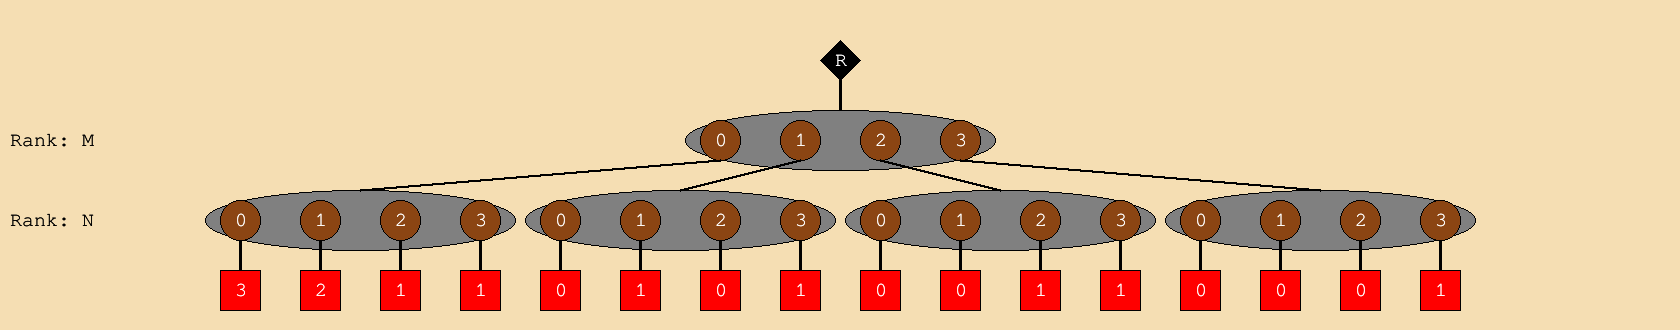

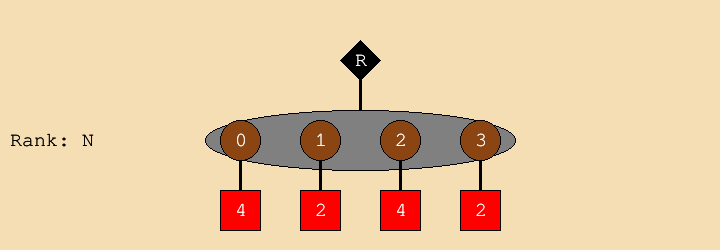

In [2]:
A_data = [[3, 2, 1, 1],
          [0, 1, 0, 1],
          [0, 0, 1, 1],
          [0, 0, 0, 1]]

N = 4

b_data = [4,
          2,
          4,
          2]

A_MN = Tensor.fromUncompressed(["M", "N"], A_data).setName("A")
B_N = Tensor.fromUncompressed(["N"], b_data).setName("b")


A = A_MN.getRoot()
# hack to induce coordinates in A where there were zeros
for j, a_j in A:
    a_j << Fiber(coords=range(N))
    
B = B_N.getRoot()

displayTensor(A)
displayTensor(B)

## Basic triangular solver (uncompressed, untiled)

In [3]:
canvas = createCanvas(A_MN, B_N)

# TODO: add skew to addActivity?
for j in range(N):
    B[j] /= A[j,j]
    canvas.addActivity((j, j), (j,), worker="diag")
    
    
    for i in range(j+1, N):
        B[i] -= B[j] * A[j,i]
        canvas.addActivity((j, j), (j,), worker="diag")
        canvas.addActivity((j, i), (i,), worker="inner")
        canvas.addFrame()
        
displayCanvas(canvas)


TypeError: unsupported operand type(s) for /=: 'CoordPayload' and 'CoordPayload'

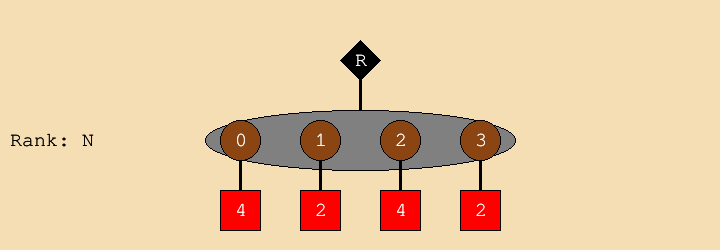

In [4]:
displayTensor(B)

## Support for compressed formats (due to Michael Pellauer)

In [ ]:
# Michael Pellauer's sparse triangular solver
A_j = A_MN.getRoot()
B_j = B_N.getRoot()
for j, (b, A_i) in B_j << A_j:
  a = A_i.getPayload(j) # lookup by coordinate
  # NOTE: Could save the pos here to make getRange() faster
  b <<= b / a # use <<= because we can't over-ride "=" in python
  for i, (b2, a) in B_j << A_i.getRange(j+1, N):
    b2 -= b * a
    
displayTensor(B_j)

In [ ]:
# Michael Pellauer's sparse triangular solver, using getSavedPos()
A_j = A_MN.getRoot()
B_j = B_N.getRoot()
for j, (b, A_i) in B_j << A_j:
  a = A_i.getPayload(j) # lookup by coordinate
  pos = A_i.getSavedPos()
  b <<= b / a
  for i, (b2, a) in B_j << A_i.getRange(j+1, N, start_pos = pos):
    b2 -= b * a
    
displayTensor(B_j)